# TD6 - Dự đoán giá Bitcoin

## Mô tả

Bitcoin là đồng tiền điện tử có giá cả và khối lượng giao dịch lớn nhất thế giới tính đến đầu năm 2018. Bitcoin được giao dịch ở các sàn thuộc nhiều quốc gia khác nhau, với giá cả xấp xỉ nhau. 

Trong TD này ta dựa vào dữ liệu về giá cả Bitcoin tại sàn giao dịch Bitfinex (trụ sở tại Anh, Đài Loan và Hongkong), được xem là một trong các sàn giao dịch tiền điện tử lớn nhất thế giới, cùng với một số dữ liệu khác, để xây dựng một mô hình đơn giản dự đoán giá của Bitcoin (BTC) theo đơn vị USD; cùng với sự thay đổi của nó trong thời gian gần. Giả sử ta là một nhà đầu tư ngắn hạn, thời điểm giá ta muốn dự đoán là 1 tuần (7 ngày) sau khi có dữ liệu hiện tại.


## Dữ liệu

Trong bài này, bạn sẽ cần làm việc với các dữ liệu sau:

- `Data/BTCPrice.csv`: Tập tin mô tả giá của BTC theo ngày từ 31/12/2015 đến hết 31/12/2017, gồm các cột: Ngày, Giá mở cửa, Giá cao nhất ngày, Giá thấp nhất ngày, Giá đóng cửa, Khối lượng giao dịch theo số BTC, Khối lượng giao dịch theo USD, và giá trung bình trong ngày. Như các loại sản phẩm tài chính khác, ta quy ước **giá BTC của ngày là giá đóng cửa (Close) của ngày đó**, và sẽ làm việc chủ yếu với cột "Close" (thay vì cột "Weighted Price"). 

 Dữ liệu này được download tại https://bitcoincharts.com/charts/bitstampUSD#rg60ztgSzm1g10zm2g25zv

In [1]:
import pandas as pd
price_data = pd.read_csv('Data/BTCPrice.csv')
price_data.head()

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
0,31/12/2015 00:00,426.09,433.89,419.99,430.89,6634.86,2833319.70,427.04
1,01/01/2016 00:00,430.89,436.00,427.20,433.82,3788.11,1640577.93,433.09
2,02/01/2016 00:00,434.87,435.99,430.42,433.55,2972.06,1287773.39,433.29
3,03/01/2016 00:00,433.20,434.09,424.06,431.04,4571.10,1959152.60,428.60
4,04/01/2016 00:00,431.54,435.86,428.44,434.17,5717.60,2474772.50,432.83


- `Data/BTCTrend.csv`: Tập tin mô tả xu hướng tìm kiếm từ "bitcoin" (sai khác một phép viết hoa) trên google trong năm 2016-2017.
- `Data/BTCNews.csv`: Tập tin liệt kê những sự kiện được cho là ảnh hưởng tích cực hay tiêu cực đến Bitcoin trong năm 2016-2017.

In [3]:
from BTCPriceForecast_Solution import *

## Yêu cầu

Bạn cần hoàn thành các hàm trong `BTCPriceForecast.py`.

Lưu ý: Mục đích của TD là làm quen với các mô hình hồi quy tuyến tính (+suy rộng) đã học như Linear Regression, Polynomial Regression, Ridge, Lasso. Do đó một số biến (liên quan đến các chỉ số kĩ thuật trong tài chính, và mô tả hiệu ứng của thông tin) sẽ được giới thiệu một cách không tự nhiên. Việc giải thích vì sao giới thiệu các biến này không thuộc phạm vi machine learning.

Bạn chạy đoạn code sau trước khi test các hàm của mình

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split #replaced by model_selection in sklearn 0.19+
from bs4 import BeautifulSoup
import statsmodels.formula.api as sm
from datetime import datetime
import time
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

SHIFT_NUMBER = 7

COLUMNS = ['open', 'high', 'low', 'close', 'volume', 'cr', 'cr-ma1', 'cr-ma2', 'cr-ma3', 'rsv_9', 'kdjk_9', 'kdjj_9', 'macd', 'macds', 'macdh', 'rs_6', 'rsi_6', 'rs_12', 'rsi_12', 'wr_6', 'wr_10', 'cci', 'cci_20', 'tr', 'atr', 'dma', 'high_delta', 'um', 'low_delta', 'dm', 'pdm', 'pdm_14', 'pdi_14', 'mdm_14', 'mdi_14', 'dx_14', 'adx', 'adxr', 'trix', 'change', 'vr', 'vr_6_sma']
REFINED_COLUMNS = [ 'cr-ma3', 'kdjk_9', 'macds', 'macdh', 'rs_6', 'rsi_6', 'wr_6', 'atr', 'dma', 'high_delta', 'um', 'dm', 'pdm_14', 'mdm_14', 'mdi_14', 'trix', 'change']

PRICE_FILE = "Data/BTCPrice.csv"
EVENT_FILE = "Data/BTCNews.csv"
TREND_FILE = "Data/BTCTrend.csv"
EVENT_PAGE = "https://99bitcoins.com/price-chart-history/"

# COLUMNS
TIMESTAMP = "Timestamp"
OPEN = "Open"
HIGH = "High"
LOW = "Low"
CLOSE = "Close"
VOLUME_BTC = "Volume (BTC)"
VOLUME_CURRENCY = "Volume (Currency)"
WEIGHTED_PRICE = "Weighted Price"

#TEST_SIZE
TEST_SIZE = 0.5
MAX_PREVIOUS_DAYS = 30

#PARAMETERS
ALPHA = np.log(2)

## Phần 1. Khởi động

### Bài 1. Chuẩn bị target

Ta cần dự đoán giá của BTC sau 1 tuần. Muốn vậy, ta xây dựng một mô hình đoán $y$ từ $X$, trong đó $X$ là ma trận tạo thành từ một số cột trong file dữ liệu, $y$ là cột "Close" bị đẩy lệch về sau 7 ngày.

1. *Hãy viết hàm **`readData(filename)`** nhận đối số là đường dẫn của một file dữ liệu dạng csv như 3 file trên và trả lại DataFrame tương ứng.*

2. *Hãy viết hàm **`getTarget(data, shift_number)`** nhận đối số **`data`** là một DataFrame có chứa cột "Close" (như dataframe ứng với file **`Data/BTCPrice.csv`**), **`shift_number`** là số ngày cần đẩy lệch, và trả lại kết quả là cột "Close" bị đẩy lệch **`shift_number`** ngày về tương lai. Kết quả này có dạng một list hoặc array tuỳ bạn chọn, có độ dài bằng số hàng của **`data`**, riêng các phần tử cuối cùng bằng 0 (vì chưa biết kết quả trong tương lai).*

Hàm của bạn cần chạy được đoạn code sau.

In [5]:
price_data = readData(PRICE_FILE) # File BTCPrice.csv 
price_data.head(10)

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
0,31/12/2015 00:00,426.09,433.89,419.99,430.89,6634.86,2833319.70,427.04
1,01/01/2016 00:00,430.89,436.00,427.20,433.82,3788.11,1640577.93,433.09
2,02/01/2016 00:00,434.87,435.99,430.42,433.55,2972.06,1287773.39,433.29
3,03/01/2016 00:00,433.20,434.09,424.06,431.04,4571.10,1959152.60,428.60
4,04/01/2016 00:00,431.54,435.86,428.44,434.17,5717.60,2474772.50,432.83
5,05/01/2016 00:00,433.31,435.39,429.50,432.43,3881.72,1677111.44,432.05
6,06/01/2016 00:00,432.45,432.67,426.54,429.56,5507.61,2369036.46,430.14
7,07/01/2016 00:00,429.99,459.16,429.25,457.00,16833.42,7536413.29,447.71
8,08/01/2016 00:00,456.87,465.00,444.51,452.70,10258.99,4654977.99,453.75
9,09/01/2016 00:00,452.02,454.00,446.68,448.84,4396.05,1976929.79,449.71


In [6]:
trend_data = readData(TREND_FILE) # File BTCTrend.csv
trend_data.head()

,Timestamp,Trend
0,01/01/2016,63
1,02/01/2016,60
2,03/01/2016,60
3,04/01/2016,65
4,05/01/2016,68


In [7]:
target = getTarget(price_data, SHIFT_NUMBER) # Kết quả là một array bắt đầu bởi giá của ngày thứ 7, kết thúc bởi 7 số 0
pd.DataFrame(getTarget(price_data, SHIFT_NUMBER)).T # Biểu diễn dưới dạng frame để dễ nhìn

,0,1,2,3,4,5,6,7,8,9,...,722,723,724,725,726,727,728,729,730,731
0,457.0,452.7,448.84,448.79,448.0,434.85,432.64,429.55,360.0,386.91,...,14340.0,12640.0,13880.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Bài 2. Mô hình AR

Mô hình AR giả thuyết rằng giá của một sản phẩm tài chính ở ngày thứ $n$ phụ thuộc vào giá của nó ở $p$ ngày trước đó ($n-1, \ldots, n-p$) theo quan hệ

$$
X_n = a_0 + \sum_{i=1}^p a_i X_{n-i} + \epsilon_n
$$

trong đó $X_n$ là giá đóng  $\epsilon_n$ là một bụi Gaussian (kì vọng 0) iid với tất cả các $n$. Đây là một mô hình hồi quy tuyến tính.

Ta thử dùng mô hình này để dự đoán không chỉ giá của ngày tiếp theo $X_n$, mà còn là giá của tương lai $X_{n+7}$. Mô hình sẽ trở thành:

$$
X_{n + SHIFT} = a_0 + a_1 X_n + a_2 X_{n-1} + \ldots + a_p X_{n-p+1} + \epsilon_n
$$

trong đó $SHIFT = 7$ là số ngày trong tương lai mà ta quan tâm.

1. *Hãy viết hàm **`getpRecentPrices(current_price, p)`** nhận đối số **`current_price`** là một array biểu thị giá hiện tại (như cột "Close") của file giá cả; **`p`** là số nguyên biểu thị số ngày liên tiếp cho đến hiện tại; và trả lại một array gồm **`p`** cột, cột 0 là giá hiện tại, cột 1 là giá ngày hôm trước, ..., cột $i$ là giá cách đây $i$ hôm. Số hàng của array bằng số hàng của **current_price**, dữ liệu nào khuyết thay bằng 0.*

    Đoạn code sau giúp test hàm của bạn.

In [8]:
price_data = readData(PRICE_FILE)
target = getTarget(price_data, SHIFT_NUMBER)
current_price = price_data.loc[:, CLOSE]
X1 = getpRecentPrices(current_price, 10)
pd.DataFrame(X1)

,0,1,2,3,4,5,6,7,8,9
0,430.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,433.82,430.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,433.55,433.82,430.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,431.04,433.55,433.82,430.89,0.00,0.00,0.00,0.00,0.00,0.00
4,434.17,431.04,433.55,433.82,430.89,0.00,0.00,0.00,0.00,0.00
5,432.43,434.17,431.04,433.55,433.82,430.89,0.00,0.00,0.00,0.00
6,429.56,432.43,434.17,431.04,433.55,433.82,430.89,0.00,0.00,0.00
7,457.00,429.56,432.43,434.17,431.04,433.55,433.82,430.89,0.00,0.00
8,452.70,457.00,429.56,432.43,434.17,431.04,433.55,433.82,430.89,0.00
9,448.84,452.70,457.00,429.56,432.43,434.17,431.04,433.55,433.82,430.89


<ol start="2">
<li> *Hãy viết hàm **`buildModel1(X_train, y_train, X_test, y_test)`** train một LinearRegression dự đoán giá 7 ngày sau bằng giá 10 ngày gần nhất tính đến hiện tại, sử dụng output của bài 1 và của câu trên, để tìm các hệ số $a_i$ trong mô hình AR nêu trên. Hàm nhận các đối số **`X_train, y_train, X_test, y_test`** là một cách chia dữ liệu **`X, y`** thành tập train/test, trong đó **`y`** có dạng như output của bài 1, **`X`** có dạng như output câu trên của bài 2. Hàm trả lại kết quả là một tuple 6 thành phần: 
    <ol>
        <li>Thành phần thứ nhất là model đã được train</li>
    
        <li>Thành phần thứ hai là các hệ số của tổ hợp tuyến tính (một array có số phần tử bằng số cột của **`X`**.</li>
    
        <li>Thành phần thứ ba là hệ số tự do của mô hình (một số thực)</li>
    
        <li>Thành phần thứ tư là kết quả dự đoán **`y`** trên tập **`X_test`** áp dụng mô hình này</li>
    
        <li>Thành phần thứ năm là RMSE của kết quả dự đoán trên tập **`X_test`**, sai khác so với **`y_test`**.</li>
        
        <li>Thành phần thứ sáu là R2 score của kết quả dự đoán trên tập **`X_test`**, sai khác so với **`y_test`**.</li>
    </ol>
    
</li>
</ol>

Đoạn code dưới đây giúp test hàm của bạn. Chú ý rằng trong thực tế, bạn sẽ cần phải tự viết đoạn code test cho phần preprocessing, nên hãy thử viết đoạn code test một cách thành thạo.

In [9]:
price_data = readData(PRICE_FILE)
current_price = price_data.loc[:, CLOSE]
X1 = getpRecentPrices(current_price, 10)
y1 = getTarget(price_data, SHIFT_NUMBER)
X1 = X1[9: len(X1) - SHIFT_NUMBER] #Bỏ các hàng khuyết dữ liệu: 9 hàng đầu và 7 hàng cuối cùng
y1 = y1[9: len(y1) - SHIFT_NUMBER]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=TEST_SIZE, random_state=0)
model1, coefs1, intercept1, y1_predict, RMSE1, score1 = buildModel1(X1_train, y1_train, X1_test, y1_test)

In [10]:
coefs1

array([ 1.17955694, -0.63209418,  0.62283975, -0.62161257,  0.68271052,
       -0.2004747 , -0.13905007,  0.9099273 , -0.35754852, -0.37324748])

In [11]:
intercept1

-2.905756155375002

In [12]:
pd.DataFrame(y1_predict).T #y1_predict là một array, ở đây in ở dạng DataFrame để dễ quan sát

,0,1,2,3,4,5,6,7,8,9,...,348,349,350,351,352,353,354,355,356,357
0,822.859363,559.906945,663.855157,611.051013,1308.48615,19988.100478,7647.833786,450.567504,962.840367,450.691943,...,649.588168,449.661297,397.460989,977.29124,4955.061842,457.462637,1105.466942,4523.601558,7812.272819,609.792923


In [13]:
RMSE1

935.109303130576

In [14]:
score1

0.9234069639086381

### Bài 3. Chọn biến quan trọng trong mô hình AR bằng RMSE

Các tính toán ở bài 2 cho thấy:
- R2 tương đối gần với 1, tức phương sai của dự đoán gần với phương sai của quan sát.
- Tuy vậy, root-mean-square error lại vào khoảng 935 (chênh lệch trung bình giữa giá dự đoán và giá quan sát xấp xỉ 1000). Chênh lệch này dễ dàng được quan sát dưới đây:

In [15]:
pd.DataFrame([y1_predict, y1_test])

,0,1,2,3,4,5,6,7,8,9,...,348,349,350,351,352,353,354,355,356,357
0,822.859363,559.906945,663.855157,611.051013,1308.48615,19988.100478,7647.833786,450.567504,962.840367,450.691943,...,649.588168,449.661297,397.460989,977.29124,4955.061842,457.462637,1105.466942,4523.601558,7812.272819,609.792923
1,798.650000,584.500000,606.710000,625.670000,1350.21000,15600.010000,6355.130000,423.510000,905.990000,420.040000,...,745.220000,416.000000,399.280000,1011.07000,5679.700000,462.330000,1130.010000,4333.380000,8717.990000,622.010000


Ta muốn chọn một giá trị $p$ tối ưu trong mô hình AR.

*Hãy viết hàm **`getRMSEList(current_price, future_price, max_p)`** nhận đối số **`current_price`** và **`future_price`** là 2 array ứng với giá hiện tại và giá trong $SHIFT$ ngày như mô tả ở bài 2, **`max_p`** là một số nguyên dương, rồi thực hiện việc train và test với mô hình AR với $p$ chạy từ 1 đến **`max_p`** bằng các linear regressor, cuối cùng trả lại root-mean-square error của $p$ linear regressors dưới dạng một list hay array. Hàm này cũng vẽ đồ thị $RMSE$ theo $p$.*

Đoạn code dưới đây giúp test hàm của bạn. 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,787.195736,873.849764,867.24436,913.486686,736.225409,759.586408,771.618451,964.663182,865.095662,935.109303,1029.863682,865.220378,1109.875205,1149.552349,954.206685,1096.882721,1348.192087,1028.080528,1028.104548,1144.320144


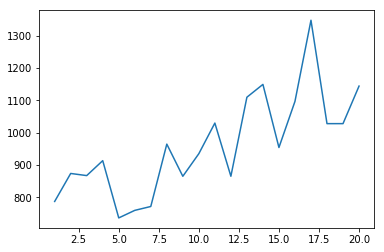

In [16]:
%matplotlib inline
price_data = readData(PRICE_FILE)
current_price = price_data.loc[:, CLOSE]
future_price = getTarget(price_data, SHIFT_NUMBER)
RMSEList = getRMSEList(current_price, future_price, 20)
pd.DataFrame(RMSEList).T # Phần tử 0: RMSE khi chọn p=1, etc.

Kết quả chạy cho thấy mô hình đề xuất $p=5$, đồng thời cũng cho thấy $p=1, 6, 7$ cho $RMSE$ không khác quá xa với kết quả tối ưu. Tuy nhiên, đề xuất $p=5$ là kết quả của cách chia ngẫu nhiên tập train/test, do đó bạn hoàn toàn có thể gặp kết quả khác (thay random_state trong hàm `train_test_split`). Trong mọi cách chia tập train/test, trường hợp $p=1$ luôn nằm trong nhóm có RMSE nhỏ nhất. Ta có thể chọn $p=1$.

### Bài 4. Chọn biến quan trọng trong mô hình AR bằng Backward Elimination

Bài này đề xuất một phương pháp khác để chọn biến quan trọng, bằng thuật toán Backward Elimination.

1. *Hãy viết hàm **`backwardEliminationOnPrice(current_price, future_price, max_p, significant_level = 0.05)`** thực hiện việc chọn biến quan trọng (significant level) bằng cách một mô hình gồm **`max_p`** giá gần nhất, loại bỏ các biến không quan trọng cho đến khi tất cả các biến đều có p-value không vượt quá **`significant_level`**; rồi trả lại danh sách các biến dưới dạng một list.*

In [17]:
price_data = readData(PRICE_FILE)
current_price = price_data.loc[:, CLOSE]
future_price = getTarget(price_data, SHIFT_NUMBER)
significant_variables = backwardEliminationOnPrice(current_price, future_price, 20)
significant_variables

[1, 7, 9, 11, 13, 14, 16, 19, 20]

Ở đây, 0 là chỉ số của cột dummy (hệ số tự do), 1 là chỉ số của cột giá hiện tại, ..., 20 là hệ số của giá 19 ngày trước đó. Tương tự như bài 3, khi thay cách chia tập train/test, ta có những list khác nhau và các chỉ số có thể bị thay đổi.

<ol start="2">
<li>*Hãy chỉnh sửa hàm **`backwardEliminationOnPrice(current_price, future_price, max_p, significant_level = 0.05)`** thành hàm **`backwardEliminationOnPrice(current_price, future_price, max_p, significant_level = 0.05, nb_random_states = 1)`** nhận thêm một đối số **`nb_random_states`** là số cách ngẫu nhiên chia dữ liệu thành các tập train/test khác nhau. Ứng với mỗi cách chia ta sẽ có một list chỉ số các biến quan trọng (\[1, 7, 9, 11, 13, 14, 16, 19, 20\]). Hàm này sẽ trả lại list các chỉ số có mặt trong tất cả các kết quả ứng với mọi cách chia train/test.* </li>
</ol>

In [18]:
price_data = readData(PRICE_FILE)
current_price = price_data.loc[:, CLOSE]
future_price = getTarget(price_data, SHIFT_NUMBER)
significant_variables = backwardEliminationOnPrice(current_price, future_price, 20, significant_level = 0.01, nb_random_states = 20)
significant_variables

[1]

Như vậy, tương tự như cách chọn biến quan trọng ở bài 3 khi xét đến yếu tố ngẫu nhiên của tập train/test, ta thấy chỉ có biến có chỉ số 1 (ứng với giá hiện tại) được chọn trong mọi (hay hầu hết) các cách chia dữ liệu 50% train/50% test ngẫu nhiên. 

## Phần 2. Độ biến thiên của giá BTC

Ở phần 1 ta đã chọn giá của BTC ở 7 ngày sau là target variable (biến cần dự đoán). Thực ra, khi đầu tư, điều ta quan tâm là giá BTC sẽ tăng hay giảm với độ chênh lệch bao nhiêu, tức quan tâm đến $X_{n+1}/X_{n} - 1$ với $X_n$ là giá ở ngày thứ $n$. Thông thường nếu tỉ lệ này nhỏ so với 1, nên ta có thể dùng xấp xỉ $\ln (1+x) \approx x$ và quan tâm đến $\log(X_{n+1}) - \log(X_n)$. Ở BTC, độ tăng giảm này khá lớn, có thể đạt đến 1 trong 1 tuần, nên ta vẫn chọn $X_{n+1} / X_{n} - 1$ là biến cần dự đoán. Ta nhân tỉ số này với 100 để dự đoán số phần trăm tăng giảm.

### Bài 5. Tính target mới
*Hãy viết hàm **`getPriceDiff(data, shift_number)`** nhận đối số **`data`** là một DataFrame có chứa cột "Close" (như dataframe ứng với file **`Data/BTCPrice.csv`**), **`shift_number`** là số ngày trong tương lai ta quan tâm đến giá, và trả lại kết quả là tỉ lệ phần trăm chênh lệch $\Delta_{n, SHIFT} = (X_{n+SHIFT}/X_n - 1) * 100$ giữa ngày đó và hiện tại. Kết quả được trả dưới dạng một list hoặc array có độ dài bằng số hàng của **`data`**, những chỗ khuyết dữ liệu thay bằng 0.*

In [19]:
price_data = readData(PRICE_FILE) # File BTCPrice.csv 
price_diff = getPriceDiff(price_data, SHIFT_NUMBER) # Kết quả là một array
pd.DataFrame(price_diff).T # Biểu diễn ở dạng DataFrame

,0,1,2,3,4,5,6,7,8,9,...,722,723,724,725,726,727,728,729,730,731
0,6.059551,4.352035,3.526698,4.117947,3.185388,0.559628,0.717013,-6.006565,-20.477137,-13.79779,...,2.356995,-13.537178,-1.962654,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Bài 6. Mô hình AR cho độ chênh lệch?

Giả sử tỉ lệ phần trăm $\Delta_{n, SHIFT}$ có thể được biểu diễn bằng:

$$
\Delta_{n, SHIFT} = b_0 + \sum_{i=1}^p b_i X_{n-i} + \epsilon_n
$$

*Hãy thực hiện các bước như ở phần 1 để xây dựng một mô hình Linear Regression tìm các hệ số $b_i$ với các $p$ khác nhau và tìm $p$ thích hợp nhất cho mô hình.*

*Hãy viết hàm **`buildModel2(X_train, y_train, X_test, y_test)`** train một LinearRegression dự đoán tỉ lệ phần trăm tăng giá ở $SHIFT$ ngày sau bằng giá $p$ ngày gần nhất tính đến hiện tại, để tìm các hệ số $n_i$ trong mô hình AR nêu trên. Hàm nhận các đối số **`X_train, y_train, X_test, y_test`** là một cách chia dữ liệu **`X, y`** thành tập train/test, trong đó **`y`** có dạng như output của bài 5, **`X`** có dạng như output câu đầu của bài 2. Hàm trả lại kết quả là một tuple 6 thành phần như ở bài 2:*
    
<ol>
<li>Thành phần thứ nhất là model đã được train</li>
<li>Thành phần thứ hai là các hệ số của tổ hợp tuyến tính (một array có số phần tử bằng số cột của **`X`**.</li>
<li>Thành phần thứ ba là hệ số tự do của mô hình (một số thực)</li>
<li>Thành phần thứ tư là kết quả dự đoán **`y`** trên tập **`X_test`** áp dụng mô hình này</li>
<li>Thành phần thứ năm là RMSE của kết quả dự đoán trên tập **`X_test`**, sai khác so với **`y_test`**.</li>
<li>Thành phần thứ sáu là R2 score của kết quả dự đoán trên tập **`X_test`**, sai khác so với **`y_test`**.</li>
</ol>

In [20]:
price_data = readData(PRICE_FILE)
current_price = price_data.loc[:, CLOSE]
future_price_diff = getPriceDiff(price_data, SHIFT_NUMBER)
X2 = getpRecentPrices(current_price, 10)
X2 = X2[9: len(X2) - SHIFT_NUMBER] #Bỏ các hàng khuyết dữ liệu: 9 hàng đầu và 7 hàng cuối cùng
y2 = future_price_diff[9: len(future_price_diff) - SHIFT_NUMBER]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=TEST_SIZE, random_state=0)
model2, coefs2, intercept2, y1_predict2, RMSE2, score2 = buildModel2(X2_train, y2_train, X2_test, y2_test)

In [21]:
coefs2, intercept2

(array([-6.64159095e-05, -5.27816074e-03,  3.24835349e-03, -3.82102995e-03,
         4.39697186e-03,  1.37427035e-04, -2.19771796e-03,  8.72902618e-03,
        -3.39276416e-03, -5.00090892e-04]), 2.4006036430958897)

In [22]:
RMSE2

12.134049361902981

Nếu so sánh với dự đoán ngây thơ: luôn dự đoán $y$ bằng trung bình của $y$ trên tập train, thậm chí ta thấy sai số này còn lớn hơn.

In [23]:
y2_naif = np.array([np.mean(y2_train)] * len(X2_test))
np.sqrt(mean_squared_error(y2_test, y2_naif))

10.997379938806352

**Biểu đồ giá 200 ngày gần nhất**

*Hãy vẽ biểu đồ độ chênh giá bitcoin sau 7 ngày tính cho 200 dữ liệu gần nhất trên **`X (= X_train union X_test`)** cùng với kết quả dự đoán trong mô hình đang sử dụng.

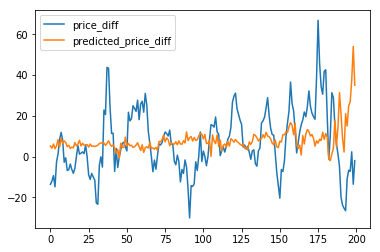

In [24]:
plt.plot(y2[-200:], label="price_diff")
plt.plot(model2.predict(X2)[-200:], label="predicted_price_diff")
plt.legend()

*Hãy viết hàm **`backwardEliminationOnPriceDiff(current_price, future_price, max_p, significant_level = 0.05)`** thực hiện việc chọn biến quan trọng (significant level) bằng cách một mô hình gồm max_p giá gần nhất, loại bỏ các biến không quan trọng cho đến khi tất cả các biến đều có p-value không vượt quá significant_level; rồi trả lại danh sách các biến dưới dạng một list.*

In [25]:
backwardEliminationOnPriceDiff(current_price, future_price_diff, 20, significant_level = 0.01, nb_random_states = 20)

[]

Kết quả cho thấy không có biến nào quan trọng ở mức dộ 0.01, cho phép nhận xét mô hình AR không dự đoán được độ chênh lệch giá.

## Phần 3. Mô hình kĩ thuật

Hai phương pháp thường được sử dụng để dự đoán giá các sản phẩm tài chính là fundamental analysis và technical analysis. Đối với phương pháp kĩ thuật, người ta tính một số chỉ số (indicator) và thông qua chúng để mô tả xu hướng giá trong tương lai.

### Bài 7. Thêm các chỉ số kĩ thuật vào dữ liệu

Để sử dụng các chỉ số kĩ thuật, bạn cần cài đặt thư viện **`statmodels`**. Thư viện này làm việc với các DataFrame có chứa các cột có tên "open", "high", "low", "close", "volume". Do đó, để sử dụng với dữ liệu của chúng ta bạn cần đổi tên các cột.

*1. Hãy viết hàm **`readAsStockDataFrame(filename)`** nhận đối số là đường dẫn đến file dữ liệu có các cột như trong file `Data/BTCPrice.csv` và trả lại kết quả là một DataFrame sao cho tên các cột tương ứng được đổi thành "open", "high", "low", "close", "volume" (volume là khối lượng BTC được giao dịch); và chỉ giữ lại 5 cột này cùng với cột "timestamp".*

In [28]:
data = readAsStockDataFrame(PRICE_FILE)
data.head()

,timestamp,open,high,low,close,volume
0,31/12/2015 00:00,426.09,433.89,419.99,430.89,6634.86
1,01/01/2016 00:00,430.89,436.00,427.20,433.82,3788.11
2,02/01/2016 00:00,434.87,435.99,430.42,433.55,2972.06
3,03/01/2016 00:00,433.20,434.09,424.06,431.04,4571.10
4,04/01/2016 00:00,431.54,435.86,428.44,434.17,5717.60


Khi đã có DataFrame trên, áp dụng hàm sau để thêm các cột chỉ số kĩ thuật và chuẩn hoá để đưa tất cả các cột về xấp xỉ phân phối Gaussian (0, 1).

In [29]:
COLUMNS = ['open', 'high', 'low', 'close', 'volume', 'cr', 'cr-ma1', 'cr-ma2', 'cr-ma3', 'rsv_9', 'kdjk_9', 'kdjj_9', 'macd', 'macds', 'macdh', 'rs_6', 'rsi_6', 'rs_12', 'rsi_12', 'wr_6', 'wr_10', 'cci', 'cci_20', 'tr', 'atr', 'dma', 'high_delta', 'um', 'low_delta', 'dm', 'pdm', 'pdm_14', 'pdi_14', 'mdm_14', 'mdi_14', 'dx_14', 'adx', 'adxr', 'trix', 'change', 'vr', 'vr_6_sma']

import stockstats as sts

def addTechnicalIndicators(simple_data):
    stock = sts.StockDataFrame(simple_data)
    stock['cr']
    stock['kdjk']
    stock['kdjd']
    stock['kdjj']
    stock['close_10_sma']
    stock['macd']
    stock['boll']
    stock['rsi_6']
    stock['rsi_12']
    stock['wr_6']
    stock['wr_10']
    stock['cci']
    stock['cci_20']
    stock['tr']
    stock['atr']
    stock['dma']
    stock['adxr']
    stock['close_12_ema']
    stock['trix']
    stock['trix_9_sma']
    stock['vr']
    stock['vr_6_sma']
    new_dataframe = pd.DataFrame(stock).loc[:, COLUMNS]
    transformed_dataframe = new_dataframe.iloc[10: len(new_dataframe) - SHIFT_NUMBER] # Bỏ các hàng khuyết dữ liệu
    scaler = StandardScaler()
    scaler.fit(transformed_dataframe)
    return pd.DataFrame(scaler.transform(transformed_dataframe), columns=COLUMNS)

<ol start="2">
<li>*Thêm đoạn gọi hàm trên vào **`readAsStockDataFrame(filename)`** để bổ sung các cột chỉ số kĩ thuật vào DataFrame và chuẩn hoá các cột dữ liệu về trung bình 0, phương sai 1.*</li>
</ol>

In [33]:
data = readAsStockDataFrame(PRICE_FILE)
data.head()

,open,high,low,close,volume,cr,cr-ma1,cr-ma2,cr-ma3,rsv_9,...,pdi_14,mdm_14,mdi_14,dx_14,adx,adxr,trix,change,vr,vr_6_sma
0,-0.557662,-0.555577,-0.567160,-0.558149,-0.684977,0.254511,-0.054549,2.535630,9.440731,-0.223739,...,0.512639,-0.389301,-0.390922,-0.017700,0.761042,1.047989,-0.435186,-0.146963,-0.961677,-0.787207
1,-0.557872,-0.555192,-0.568139,-0.558405,-0.154990,0.013675,0.406567,1.990468,6.653909,-0.299411,...,0.109721,-0.386393,-0.291621,-0.491732,0.349655,0.856236,-0.416393,-0.189552,-1.131634,-0.838256
2,-0.557937,-0.556164,-0.569415,-0.562664,-0.298147,-0.298446,0.591809,1.894016,4.221087,-1.745237,...,-0.216358,-0.381915,-0.136020,-1.063830,-0.155752,0.554994,-0.428084,-0.902234,-1.235631,-0.847340
3,-0.562264,-0.559159,-0.572859,-0.563380,0.127178,-0.620990,0.687280,1.880327,3.147333,-1.804377,...,-0.477820,-0.363203,0.573056,-0.839978,-0.428006,0.253150,-0.457949,-0.275354,-1.344351,-1.097693
4,-0.562965,-0.560509,-0.571985,-0.564381,-0.638554,-0.664228,0.828384,1.773829,2.466648,-2.103575,...,-0.617778,-0.371092,0.349826,-0.839978,-0.620778,-0.023577,-0.499683,-0.328561,-1.381465,-1.223595


### Bài 8. Linear Regression trên dữ liệu kĩ thuật

*Lấy $X$ là dữ liệu kĩ thuật output của bài 7 và $y$ là độ chênh lệch giá của 7 ngày sau, viết hàm **`buildModel3(X_train, y_train, X_test, y_test)`** train một LinearRegression theo **`X_train`, `y_train`** rồi dự đoán giá **`X_test`** kiểm tra bằng **`y_test`** *

Lưu ý rằng X có số hàng giảm đi sau khi bỏ các hàng khuyết dữ liệu, nên ở đoạn code sau ta bỏ các hàng tương ứng của $y$. Kiểm tra hàm của bạn bằng đoạn code test.

In [34]:
technical_data = readAsStockDataFrame(PRICE_FILE)
price_data = readData(PRICE_FILE)
price_diff = getPriceDiff(price_data, SHIFT_NUMBER)
X3 = technical_data
y3 = price_diff[10: len(price_diff) - SHIFT_NUMBER]
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=TEST_SIZE, random_state=0)
model3, coefs3, intercept3, y3_predict, RMSE3, score3 = buildModel3(X3_train, y3_train, X3_test, y3_test)

In [35]:
coefs3, intercept3

(array([-8.95687615e+01, -3.30204735e+03,  3.06912711e+03, -4.65246059e+01,
        -2.29734999e+00, -9.18862442e-01, -1.21752036e+00,  2.15990590e+00,
        -2.02055527e+00, -1.87639294e+00, -4.86511827e+00, -6.41731505e-02,
        -1.92423252e+00, -2.93017689e+00,  3.36614062e+00,  1.39141887e+00,
         1.39077432e+01, -1.07249119e+00, -6.10122770e+00,  3.10729644e+00,
        -2.09425508e+00,  3.55980511e+00, -3.80140550e+00,  4.58495658e+02,
        -4.45405840e+00, -8.05719310e+00, -8.60893298e+00,  3.18297846e+01,
        -9.61027916e-01, -2.48817087e+00, -2.92514352e+01, -2.49799093e+00,
         1.30093413e-01,  3.25346436e+00,  1.53855039e+00,  2.35884068e+00,
        -4.33218512e+00,  3.51929872e+00,  2.71819164e+00, -1.35978671e+00,
        -2.96215545e-01,  1.72408476e+00]), 4.375715086380031)

In [36]:
RMSE3

10.177908401176442

In [37]:
score3

0.11700720586575208

*Vẽ đồ thị chênh lệch giá tuần của 200 ngày gần nhất theo thực tế và dự đoán với mô hình 3.*

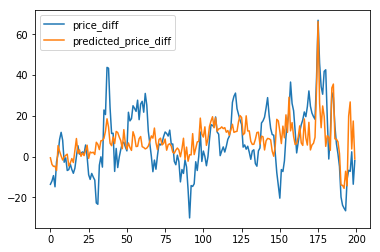

In [38]:
plt.plot(y3[-200:], label="price_diff")
plt.plot(model3.predict(X3)[-200:], label="predicted_price_diff")
plt.legend()

### Bài 9. Giả sử mô hình đang overfitting...

Bài này minh hoạ việc sử dụng feature selection trên một mô hình không overfitting sẽ nhìn chung không cải thiện được kết quả.

1. *Giả sử mô hình đang overfitting, dùng backward elimination để chọn các biến kĩ thuật quan trọng trong mô hình trên. Bạn có thể viết hàm **`backwardEliminationOnTechnicalData`** tương tự như ở phần 1, 2 để chọn các biến quan trọng theo một ngưỡng xác định trước. Chú ý rằng khi cách chia train/test thay đổi, sẽ không có biến nào xuất hiện trong tất cả các kết quả. Bạn có thể chọn những biến xuất hiện trong nhiều kết quả nhất. Ví dụ, cho 30 phép chia train/test và chọn các biến xuất hiện trong >= 20 kết quả.*

Kiểm tra kết quả bằng đoạn code sau (các biến lựa chọn có thể khác)

In [39]:
technical_data = readAsStockDataFrame(PRICE_FILE)
price_diff = getPriceDiff(price_data, SHIFT_NUMBER)
variable_selection = backwardEliminationOnTechnicalData(technical_data, price_diff, 0.1, 50)
variable_selection

[0, 1, 8, 9, 11, 16, 17, 22, 27, 40]

Dưới đây, hàm **`getColumnNameFromIndices(indices)`** được viết sẵn trả lại tên các cột tương ứng với chỉ số. Nó cho phép người khảo sát hiểu các biến có ý nghĩa gì.

In [40]:
REFINED_COLUMNS = getColumnNameFromIndices(variable_selection)
REFINED_COLUMNS

['vr_6_sma',
 'open',
 'cr-ma2',
 'cr-ma3',
 'kdjk_9',
 'rs_6',
 'rsi_6',
 'cci',
 'high_delta',
 'change']

<ol start="2">
<li>*Dựa trên kết quả chọn biến, viết hàm **`buildModel4(X_train, y_train, X_test, y_test)`** train lại model LinearRegression nhưng chỉ trên các biến đã được chọn và tính các hệ số, RMSE trên tập test.*</li>
</ol>

In [41]:
technical_data = readAsStockDataFrame(PRICE_FILE)
REFINED_COLUMNS = getColumnNameFromIndices(variable_selection)
refined_technical_data = technical_data.loc[:, REFINED_COLUMNS]
price_diff = getPriceDiff(price_data, SHIFT_NUMBER)
X4 = refined_technical_data
y4 = price_diff[10: len(price_diff) - SHIFT_NUMBER]
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=TEST_SIZE, random_state=0)
model4, coefs4, intercept4, y4_predict, RMSE4, score4 = buildModel4(X4_train, y4_train, X4_test, y4_test)

In [42]:
coefs4, intercept4

(array([-1.50081231,  1.80297088,  1.36029255, -1.87375089, -3.38263938,
         1.20351048,  3.28764352,  0.82167238, -1.4776895 , -0.60175674]),
 4.148188742602574)

In [43]:
RMSE4

10.546203009098091

Như vậy, việc chọn biến quan trọng không cho phép giảm sai số. Điều này minh hoạ việc mô hình đang không overfitting. Bạn có thể so sánh với sai số trên tập train và thấy chúng có cùng mức độ sai số. Sai số lớn như nhau trên cả tập train và test chứng tỏ mô hình đang không overfitting.

In [44]:
y4_predict_train = model4.predict(X4_train)
np.sqrt(mean_squared_error(y4_train, y4_predict_train))

10.211131942337394

### Bài 10. Polynomial Regression

*Lấy $X$ là dữ liệu kĩ thuật output của bài 7 và $y$ là độ chênh lệch giá của 7 ngày sau,  viết hàm **`buildModel5(X_train, y_train, X_test, y_test)`** sử dụng Polynomial Regression bậc 2 để xây dựng mô hình dự đoán $y$ từ $X$. Tính RMSE, R2 score với mô hình này trên tập test. So sánh với sai số trên tập train để phát hiện mô hình có đang overfitting không. Vẽ đồ thị giá 200 ngày gần nhất (thực tế, dự đoán) để minh hoạ.*

In [45]:
technical_data = readAsStockDataFrame(PRICE_FILE)
price_diff = getPriceDiff(price_data, SHIFT_NUMBER)
X5 = technical_data[:]
y5 = price_diff[10: len(price_diff) - SHIFT_NUMBER]
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=TEST_SIZE, random_state=0)
model5, coefs5, intercept5, y5_predict, RMSE5, score5 = buildModel5(X5_train, y5_train, X5_test, y5_test)

In [46]:
RMSE5

86.93831016933417

RMSE quá cao, và sự bất thường của đồ thị đường dự đoán cho phép nhận xét mô hình đang overfitting. Thật vậy, nếu sử dụng tập train, sai số sẽ nhỏ hơn nhiều, xấp xỉ 0. Như vậy, mô hình bị overfitting trên tập train đang sử dụng.

In [47]:
# Đoạn code này ví dụ việc tính RMSE trên tập train. Đoạn code của bạn có thể khác
y5_predict_train = model5.predict(PolynomialFeatures(2).fit_transform(X5_train))
np.sqrt(mean_squared_error(y5_train, y5_predict_train))

5.452984231312599e-13

Đồ thị minh hoạ: ta thấy sự cao bất thường của đường dự đoán ở đoạn dữ liệu 190-200.

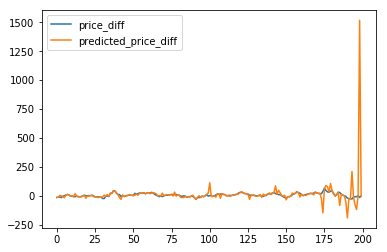

In [48]:
plt.plot(y5[-200:], label="price_diff")
plt.plot(model5.predict(PolynomialFeatures(2).fit_transform(X5))[-200:], label="predicted_price_diff")
plt.legend()

Thậm chí nếu giảm size của tập test, sai số giữa tập train và tập test thậm chí còn có khoảng cách lớn hơn

In [49]:
TEST_SIZE_2 = 0.1
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=TEST_SIZE_2, random_state=0)
model5, coefs5, intercept5, y5_predict, RMSE5, score5 = buildModel5(X5_train, y5_train, X5_test, y5_test)
print "Error on test set: ", np.sqrt(mean_squared_error(y5_test, y5_predict))
y5_predict_train = model5.predict(PolynomialFeatures(2).fit_transform(X5_train))
print "Error on training set: ", np.sqrt(mean_squared_error(y5_train, y5_predict_train))

Error on test set:  205.23785803532968
Error on training set:  5.8461524435091435e-12


Mô hình đang overfitting do đó việc giảm số biến là cần thiết. Thay vì sử dụng backward elimination, ta có thể sử dụng Lasso.

### Bài 11. Lasso

*Lấy $X$ là dữ liệu kĩ thuật output của bài 7 và $y$ là độ chênh lệch giá của 7 ngày sau, viết hàm **`buildModel6(X_train, y_train, X_test, y_test, alpha)`** sử dụng Lasso trên Polynomial Regression bậc 2 để xây dựng mô hình dự đoán $y$ từ $X$, **`alpha`** là hệ số phạt. Vẫn trả kết quả ở dạng bộ 6 phần tử như các mô hình trước. Chọn hệ số phạt $\alpha$ tốt nhất cho cách chọn train/test hiện tại. Tính RMSE, R2 score với mô hình này trên tập test. Vẽ đồ thị giá 200 ngày gần nhất (thực tế, dự đoán) để minh hoạ. Cẩn thận: khi dùng Lasso, chú ý số bước lặp để bài toán optimization hội tụ.*

In [56]:
technical_data = readAsStockDataFrame(PRICE_FILE)
price_diff = getPriceDiff(price_data, SHIFT_NUMBER)
X6 = technical_data[:]
y6 = price_diff[10: len(price_diff) - SHIFT_NUMBER]
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size=TEST_SIZE, random_state=0)
alpha6 = 0.11
model6, coefs6, intercept6, y6_predict, RMSE6, score6 = buildModel6(X6_train, y6_train, X6_test, y6_test, alpha6)
RMSE6

Nb_iterations used:  12313


9.342546946384736

Các biến quan trọng (có 104 biến có hệ số lớn hơn 0.01)

In [57]:
important_variables = filter(lambda i: abs(coefs6[i]) > 1e-2, range(len(model6.coef_)))
pd.DataFrame(important_variables).T

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,5,9,11,12,33,35,41,42,126,128,...,930,931,932,934,935,936,937,939,940,941


*Hãy tìm lại ý nghĩa các biến này bằng cách viết hàm **`indToNameOnPolynomialRegressionDegree2(initial_columns, selected_indices)`** nhận đối số **`initial_columns`** là list tên các cột ban đầu (có dạng như `COLUMNS`), và **`selected_indices`** là list chỉ số các biến được chọn (có dạng như `important_variables` trong ví dụ trên), trả lại một từ điển ứng mỗi chỉ số ý nghĩa biến (chỉ số đó chỉ biến nào, hoặc chỉ tích của 2 biến nào trong đa thức bậc 2)*

In [58]:
important_variables_dict = indToNameOnPolynomialRegressionDegree2(COLUMNS, important_variables) # Một từ điển
pd.DataFrame([important_variables_dict.keys(), important_variables_dict.values()]).T

,0,1
0,5,1 * volume
1,9,1 * cr-ma3
2,11,1 * kdjk_9
3,12,1 * kdjj_9
4,526,macds * low_delta
5,33,1 * pdi_14
6,35,1 * mdi_14
7,550,macdh * atr
8,41,1 * vr
9,42,1 * vr_6_sma


Sau khi hàm trên được viết, ta có thể in ra dạng "dễ đọc" của mô hình như sau:

In [59]:
def getModelReadableForm(coefs, important_variables_dict):
    S = ""
    for k, V in sorted(important_variables_dict.items(), key = lambda x: -abs(coefs[x[0]])):
        S += " + (%.2f) * %s " % (coefs[k], V)
    return S

getModelReadableForm(model6.coef_, important_variables_dict)

' + (5.60) * low * low  + (-4.34) * macdh * adxr  + (-3.80) * dma * dma  + (-3.79) * low * cr-ma3  + (-3.42) * kdjk_9 * adxr  + (3.02) * cr-ma1 * tr  + (-2.61) * low * cci  + (-2.58) * 1 * kdjj_9  + (2.43) * cci_20 * trix  + (2.42) * adxr * vr_6_sma  + (2.40) * rsi_12 * adxr  + (-2.26) * pdi_14 * vr_6_sma  + (-2.00) * atr * vr  + (-2.00) * 1 * cr-ma3  + (1.93) * trix * trix  + (1.86) * adxr * vr  + (-1.80) * cr * vr_6_sma  + (1.71) * mdm_14 * adxr  + (-1.70) * 1 * kdjk_9  + (-1.66) * low * vr_6_sma  + (1.65) * cr-ma3 * vr  + (-1.60) * volume * kdjk_9  + (-1.56) * 1 * mdi_14  + (-1.56) * adx * change  + (-1.51) * dma * vr  + (-1.45) * volume * high_delta  + (-1.41) * volume * mdi_14  + (1.38) * 1 * pdi_14  + (-1.36) * cr * adxr  + (1.31) * rsi_12 * rsi_12  + (-1.27) * wr_6 * dma  + (-1.26) * pdi_14 * adxr  + (1.20) * 1 * vr_6_sma  + (1.12) * rs_6 * dma  + (1.11) * mdi_14 * dx_14  + (1.04) * cr-ma3 * wr_10  + (-1.04) * cr-ma2 * adxr  + (0.99) * rsi_12 * dx_14  + (0.96) * adxr * adxr  + (

Kết quả dự đoán cho 200 ngày gần nhất:

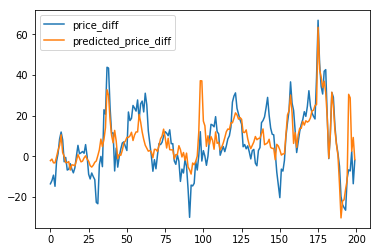

In [60]:
plt.plot(y6[-200:], label="price_diff")
plt.plot(model6.predict(PolynomialFeatures(2).fit_transform(X6)[-200:]), label="predicted_price_diff")
plt.legend()

Như vậy, đến giờ ta đã đưa ra một mô hình mà sai số dự đoán trung bình (đo bằng RMSE) giảm từ 12.13% xuống 9.34%. Sai số này nhỏ hơn sai số của mô hình ngây thơ (luôn đoán độ tăng giá bằng độ tăng trung bình trên tập train)

## Phần 4 - Mô hình dựa vào thông tin

### Bài 12. Tính các chỉ số thông tin

Bây giờ ta dựa vào hai nguồn thông tin mới là google trend (xu hướng tìm kiếm) từ khoá "bitcoin" trên google theo thời gian và dữ liệu một số thông tin tích cực và tiêu cực liên quan đến bitcoin. File `Data/BTCTrend.csv` cho ta chỉ số tìm kiếm theo ngày, các chỉ số này tỉ lệ thuận với lượng tìm kiếm trên google. File `Data/BTCNews.csv` cho ta các thông tin sắp xếp theo thời gian. Ta chỉ quan tâm đến cột cuối cùng: 1 cho biết thông tin là tích cực, có khả năng khiến BTC tăng giá; -1 là tiêu cực, có khả năng khiến BTC giảm giá. Ngày xảy ra các sự kiện này không trùng nhau.

Gọi $X_n$ là giá của bitcoin tại ngày thứ $n$, $T_n$ là chỉ số xu hướng tìm kiếm ngày đó. Gọi $s_m$ là dấu của ngày xảy ra sự kiện, bằng 1 hoặc -1 nếu ngày đó xảy ra sự kiện tích cực hay tiêu cực, bằng 0 nếu không xảy ra sự kiện gì. Gọi $S$ là tập hợp tất cả các ngày có xảy ra một sự kiện tích cực hoặc tiêu cực. Ta xây dựng thêm một chỉ số, được gọi là hệ số thông tin của ngày, chỉ số này được tính như sau:

$$
H_n = \sum_{m \in S, n \geq m} \exp(-\alpha/(n - m)) * s_m
$$

Công thức này có nghĩa là: hệ số thông tin của một ngày bằng tổng độ ảnh hưởng của các thông tin diễn ra trước đó. Độ ảnh hưởng của thông tin giảm theo hàm mũ trên số ngày đã diễn ra thông tin: nếu thông tin diễn ra hôm nay, nó có độ ảnh hưởng bằng 1 hoặc -1, nếu diễn ra hôm qua, nó có độ ảnh hưởng $\pm e^{-\alpha}$; nếu diễn ra hôm trước, nó có độ ảnh hưởng bằng $$.

*Hãy viết hàm **`getTCoefficient(price_data, trend_data)`** nhận đối số là 2 DataFrame **`price_data`** đọc từ `Data/BTCPrice.csv` và **`trend_data`** đọc từ `Data/BTCTrend.csv`* và trả lại $T_n$, một list hay array có độ dài bằng độ dài **`price_data`**, tính có các ngày tương ứng với các ngày trong **`price_data`**. Hãy chuẩn hoá kết quả này bằng biến đổi tuyến tính để có trung bình 0, phương sai 1. (Khi chuẩn hoá, bỏ qua ngày 31/12/2015 vì không có dữ liệu, chỉ tính trung bình và độ lệch chuẩn trên những ngày còn lại)*

*Hãy viết hàm **`getHCoefficient(price_data, news_data, alpha)`** nhận đối số là 2 DataFrame **`price_data`** đọc từ `Data/BTCPrice.csv`, **`news_data`** đọc từ `Data/BTCNews.csv` cùng một đối số **`alpha`** là một số thực dương; và trả lại $H_n$ như mô tả trên, dưới dạng một list hay array có độ dài bằng độ dài **`price_data`**, tính có các ngày tương ứng với các ngày trong **`price_data`**. Hãy chuẩn hoá kết quả này để có trung bình 0, phương sai 1.*

*Hãy viết hàm **`getLogTCoefficient(price_data, trend_data)`** nhận đối số là 2 DataFrame **`price_data`** đọc từ `Data/BTCPrice.csv` và **`trend_data`** đọc từ `Data/BTCTrend.csv` và trả lại $\ln T_n$, một list hay array có độ dài bằng độ dài **`price_data`**, tính có các ngày tương ứng với các ngày trong **`price_data`**. Hãy chuẩn hoá kết quả này bằng biến đổi tuyến tính để có trung bình 0, phương sai 1. (Khi chuẩn hoá, bỏ qua ngày 31/12/2015 vì không có dữ liệu, chỉ tính trung bình và độ lệch chuẩn trên những ngày còn lại)*


In [61]:
trend_data = readData(TREND_FILE)
trend_data.head()

,Timestamp,Trend
0,01/01/2016,63
1,02/01/2016,60
2,03/01/2016,60
3,04/01/2016,65
4,05/01/2016,68


In [62]:
news_data = readData(EVENT_FILE)
news_data.head()

,Timestamp,Title,Reference,Score
0,11/01/2016,The US-based exchange Cryptsy declared bankrup...,"""Cryptsy CEO Stole Millions From Exchange, Cou...",-1
1,13/01/2016,Mike Hearn Quits Bitcoin (a.k.a The Hearnia) -...,https://www.cryptocoinsnews.com/mike-hearn-say...,-1
2,16/01/2016,� Le�Bitcoin�est un �chec �. C'est un de ses d...,NaN,-1
3,20/01/2016,Bitcoin : les Pays-Bas arr�tent 10 hommes susp...,http://www.clubic.com/antivirus-securite-infor...,-1
4,17/02/2016,IBM wants to move blockchain tech beyond Bitco...,https://arstechnica.com/information-technology...,1


In [63]:
price_data = readData(PRICE_FILE)
trend_data = readData(TREND_FILE)
TCoefficient = getTCoefficient(price_data, trend_data)
pd.DataFrame(TCoefficient).T 

,0,1,2,3,4,5,6,7,8,9,...,722,723,724,725,726,727,728,729,730,731
0,-0.607179,-0.459056,-0.46611,-0.46611,-0.454354,-0.4473,-0.456705,-0.428491,-0.423789,-0.452003,...,8.463554,5.01677,3.474416,3.112339,3.020644,2.839606,2.750262,2.477529,2.385834,1.751024


In [64]:
price_data = readData(PRICE_FILE)
news_data = readData(EVENT_FILE)
HCoefficient = getHCoefficient(price_data, news_data, ALPHA)
pd.DataFrame(HCoefficient).T # Các giá trị đầu tiên bằng nhau vì không có sự kiện

,0,1,2,3,4,5,6,7,8,9,...,722,723,724,725,726,727,728,729,730,731
0,-0.065613,-0.065613,-0.065613,-0.065613,-0.065613,-0.065613,-0.065613,-0.065613,-0.065613,-0.065613,...,-0.278343,-0.171978,-0.118796,-0.092204,-0.078909,-3.487617,-1.776615,-0.921114,-0.493364,-0.279488


In [65]:
# kiểm tra ngày có sự kiện đầu tiên là ngày 11/1 (ngày có chỉ số 11, vì ngày 31/12/2015 có chỉ số 0)
pd.DataFrame(HCoefficient).head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.065613,-0.065613,-0.065613,-0.065613,-0.065613,-0.065613,-0.065613,-0.065613,-0.065613,-0.065613,-0.065613,-3.480969,-1.773291,-4.334808,-2.20021


In [66]:
price_data = readData(PRICE_FILE)
trend_data = readData(TREND_FILE)
logTCoefficient = getLogTCoefficient(price_data, trend_data)
pd.DataFrame(logTCoefficient).T 

,0,1,2,3,4,5,6,7,8,9,...,722,723,724,725,726,727,728,729,730,731
0,-5.417552,-0.913431,-0.966472,-0.966472,-0.879455,-0.830403,-0.89631,-0.709487,-0.681248,-0.862857,...,3.559854,3.040186,2.691711,2.590723,2.563587,2.507936,2.479385,2.387281,2.354475,2.095325


### Bài 13. Mô hình dựa vào thông tin

Ta dự đoán tỉ lệ phần trăm tăng giá BTC sau 7 ngày là một đa thức theo các biến $H_n, T_n, \ln T_n$. 

*Lấy $X$ là dữ liệu tạo thành từ 3 cột $H_n$, $T_n$, $\ln T_n$, và $y$ là độ chênh lệch giá của 7 ngày sau, viết hàm **`buildModel7(X_train, y_train, X_test, y_test)`** xây dựng Polynomial Regression bậc 2 dự đoán $y$ từ $X$, vẫn trả kết quả ở dạng bộ 6 phần tử như các mô hình trước. Tính RMSE, vẽ đồ thị giá 200 ngày gần nhất.*

In [112]:
price_data = readData(PRICE_FILE)
news_data = readData(EVENT_FILE)
trend_data = readData(TREND_FILE)
TCoefficient = getTCoefficient(price_data, trend_data)
TCoefficient = np.array(TCoefficient).reshape(len(TCoefficient), 1)
HCoefficient = getHCoefficient(price_data, news_data, ALPHA)
HCoefficient = np.array(HCoefficient).reshape(len(HCoefficient), 1)
logTCoefficient = getLogTCoefficient(price_data, trend_data)
logTCoefficient = np.array(logTCoefficient).reshape(len(logTCoefficient), 1)
information_data = np.concatenate([TCoefficient, logTCoefficient, HCoefficient], axis = 1)
price_diff = getPriceDiff(price_data, SHIFT_NUMBER)
X7 = information_data[10: len(price_diff) - SHIFT_NUMBER] #Lấy từ ngày đầu tiên có thông tin
y7 = price_diff[10: len(price_diff) - SHIFT_NUMBER]
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, test_size=TEST_SIZE, random_state=0)

model7, coefs7, intercept7, y7_predict, RMSE7, score7 = buildModel7(X7_train, y7_train, X7_test, y7_test)
RMSE7

10.544458029012162

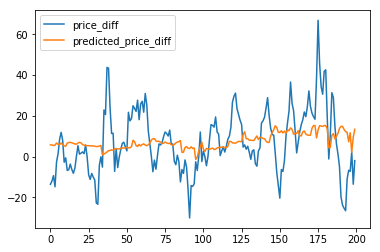

In [113]:
plt.plot(y7[-200:], label="price_diff")
plt.plot(model7.predict(PolynomialFeatures(2).fit_transform(X7))[-200:], label="predicted_price_diff")
plt.legend()

In [73]:
coefs7

array([ 7.00311546e+01,  2.50207816e+02, -9.46881928e+01,  1.65967921e+00,
        4.41411437e+00, -6.49611002e+01, -2.79800934e-01, -1.60091536e+01,
        2.22393493e-01, -4.61889215e-01])

Sử dụng mô hình thông tin với cách xử lí của ta cho kết quả tốt hơn nhẹ so với mô hình ngây thơ, nhưng kém mô hình kĩ thuật.

## Phần 5 - Mô hình kết hợp

### Bài 14. Kết hợp mô hình kĩ thuật và mô hình thông tin

Ta dự đoán tỉ lệ phần trăm tăng giá BTC sau 7 ngày là một đa thức bậc 2 theo cả các biến kĩ thuật trong phần 3 và 3 biến thông tin ở cuối bài 13.

*Lấy $X$ là dữ liệu tạo thành từ tất cả các cột trong mô hình kĩ thuật và thêm 3 cột $H_n$, $T_n$, $\ln T_n$, $y$ là độ chênh lệch giá của 7 ngày sau, viết hàm **`buildModel8(X_train, y_train, X_test, y_test)`** xây dựng Polynomial Regression bậc 2 dự đoán $y$ từ $X$, vẫn trả kết quả ở dạng bộ 6 phần tử như các mô hình trước. Tính RMSE, vẽ đồ thị giá 200 ngày gần nhất.*

Đoạn code dưới đây dùng để test. Nhắc lại, bạn cần có khả năng tự viết lại đoạn code này.

In [116]:
price_data = readData(PRICE_FILE)
news_data = readData(EVENT_FILE)
trend_data = readData(TREND_FILE)
price_diff = getPriceDiff(price_data, SHIFT_NUMBER)

TCoefficient = getTCoefficient(price_data, trend_data)
TCoefficient = np.array(TCoefficient).reshape(len(TCoefficient), 1)
HCoefficient = getHCoefficient(price_data, news_data, ALPHA)
HCoefficient = np.array(HCoefficient).reshape(len(HCoefficient), 1)
logTCoefficient = getLogTCoefficient(price_data, trend_data)
logTCoefficient = np.array(logTCoefficient).reshape(len(logTCoefficient), 1)
information_data = np.concatenate([TCoefficient, logTCoefficient, HCoefficient], axis = 1)
X8_info = information_data[10: len(price_diff) - SHIFT_NUMBER] #Lấy từ ngày đầu tiên có thông tin

technical_data = readAsStockDataFrame(PRICE_FILE)
price_diff = getPriceDiff(price_data, SHIFT_NUMBER)
X8_tech = technical_data[:]

X8 = np.concatenate([X8_info, X8_tech], axis = 1)

FULL_COLUMNS = COLUMNS + ["T_n", "Log_T_n", "H_n"]

y8 = price_diff[10: len(price_diff) - SHIFT_NUMBER]
X8_train, X8_test, y8_train, y8_test = train_test_split(X8, y8, test_size=TEST_SIZE, random_state=0)
model8, coefs8, intercept8, y8_predict, RMSE8, score8 = buildModel8(X8_train, y8_train, X8_test, y8_test)

In [117]:
RMSE8

76.542897674416

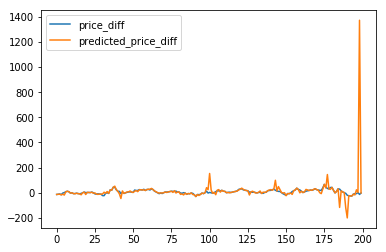

In [118]:
plt.plot(y8[-200:], label="price_diff")
plt.plot(model8.predict(PolynomialFeatures(2).fit_transform(X8))[-200:], label="predicted_price_diff")
plt.legend()

RMSE lớn và khác xa so với tập train chứng tỏ mô hình overfit trên tập train. Ta dùng Lasso để điều hoà.

*Lấy $X$ là dữ liệu tạo thành từ tất cả các cột trong mô hình kĩ thuật và thêm 3 cột $H_n$, $T_n$, $\ln T_n$, $y$ là độ chênh lệch giá của 7 ngày sau, viết hàm **`buildModel9(X_train, y_train, X_test, y_test, alpha)`** xây dựng mô hình Lasso trên Polynomial Regression bậc 2 dự đoán $y$ từ $X$, vẫn trả kết quả ở dạng bộ 6 phần tử như các mô hình trước. Chọn $\alpha$ tối ưu cho tập test. Tính RMSE, vẽ đồ thị giá 200 ngày gần nhất.*

In [119]:
price_data = readData(PRICE_FILE)
news_data = readData(EVENT_FILE)
trend_data = readData(TREND_FILE)
price_diff = getPriceDiff(price_data, SHIFT_NUMBER)

TCoefficient = getTCoefficient(price_data, trend_data)
TCoefficient = np.array(TCoefficient).reshape(len(TCoefficient), 1)
HCoefficient = getHCoefficient(price_data, news_data, ALPHA)
HCoefficient = np.array(HCoefficient).reshape(len(HCoefficient), 1)
logTCoefficient = getLogTCoefficient(price_data, trend_data)
logTCoefficient = np.array(logTCoefficient).reshape(len(logTCoefficient), 1)
information_data = np.concatenate([TCoefficient, logTCoefficient, HCoefficient], axis = 1)
X9_info = information_data[10: len(price_diff) - SHIFT_NUMBER] 

technical_data = readAsStockDataFrame(PRICE_FILE)
price_diff = getPriceDiff(price_data, SHIFT_NUMBER)
X9_tech = technical_data

X9 = np.concatenate([X9_tech, X9_info], axis = 1)

FULL_COLUMNS = COLUMNS + ["T_n", "Log_T_n", "H_n"]

y9 = price_diff[10: len(price_diff) - SHIFT_NUMBER]
X9_train, X9_test, y9_train, y9_test = train_test_split(X9, y9, test_size=TEST_SIZE, random_state=0)

model9, coefs9, intercept9, y9_predict, RMSE9, score9 = buildModel9(X9_train, y9_train, X9_test, y9_test, 0.3)
RMSE9

Nb_iterations used:  6021


9.199798639276453

Cuối cùng, bằng cách thay đổi giá trị của `ALPHA` (hệ số giảm ảnh hưởng của thông tin) và alpha (hệ số phạt trong Lasso), ta có thể cải thiện nhẹ mô hình.

In [120]:
price_data = readData(PRICE_FILE)
news_data = readData(EVENT_FILE)
trend_data = readData(TREND_FILE)
price_diff = getPriceDiff(price_data, SHIFT_NUMBER)

ALPHA = 0.1

TCoefficient = getTCoefficient(price_data, trend_data)
TCoefficient = np.array(TCoefficient).reshape(len(TCoefficient), 1)
HCoefficient = getHCoefficient(price_data, news_data, ALPHA)
HCoefficient = np.array(HCoefficient).reshape(len(HCoefficient), 1)
logTCoefficient = getLogTCoefficient(price_data, trend_data)
logTCoefficient = np.array(logTCoefficient).reshape(len(logTCoefficient), 1)
information_data = np.concatenate([TCoefficient, logTCoefficient, HCoefficient], axis = 1)
X9_info = information_data[10: len(price_diff) - SHIFT_NUMBER] 

technical_data = readAsStockDataFrame(PRICE_FILE)
price_diff = getPriceDiff(price_data, SHIFT_NUMBER)
X9_tech = technical_data

X9 = np.concatenate([X9_tech, X9_info], axis = 1)

FULL_COLUMNS = COLUMNS + ["T_n", "Log_T_n", "H_n"]

y9 = price_diff[10: len(price_diff) - SHIFT_NUMBER]
X9_train, X9_test, y9_train, y9_test = train_test_split(X9, y9, test_size=TEST_SIZE, random_state=0)

model9, coefs9, intercept9, y9_predict, RMSE9, score9 = buildModel9(X9_train, y9_train, X9_test, y9_test, 0.1)
RMSE9

Nb_iterations used:  42529


8.928270351686729

Như vậy, việc đưa thêm các biến thông tin cải thiện RMSE từ 9.34% xuống 8.93%. Độ giảm này không quá đáng kể so với mô hình thuần kĩ thuật. Có thể giải thích hiện tượng này: hoặc chất lượng của dữ liệu thông tin không tốt dẫn đến mô hình  hoặc cách số hoá thông tin của ta chưa hợp lí, hoặc mô hình kĩ thuật chế ngự (dominate) và đã phần nào bao hàm mô hình thông tin. 

Trong khuôn khổ khảo sát các mô hình đơn giản ở TD này, ta có thể dừng tại mô hình này. Phần còn lại khảo sát các biến quan trọng và vẽ đồ thị mô hình.

In [109]:
important_variables = filter(lambda i: abs(model9.coef_[i]) > 1e-2, range(len(model9.coef_)))
pd.DataFrame(important_variables).T

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,115
0,5,9,11,12,22,35,42,45,111,135,...,1048,1049,1053,1060,1061,1062,1065,1066,1076,1080


In [110]:
important_variables_dict = indToNameOnPolynomialRegressionDegree2(FULL_COLUMNS, important_variables) # Một từ điển
pd.DataFrame([important_variables_dict.keys(), important_variables_dict.values(), ]).T

,0,1
0,1024,mdi_14 * Log_T_n
1,1026,dx_14 * dx_14
2,5,1 * volume
3,518,kdjj_9 * Log_T_n
4,519,kdjj_9 * H_n
5,1032,dx_14 * vr_6_sma
6,9,1 * cr-ma3
7,11,1 * kdjk_9
8,12,1 * kdjj_9
9,1039,adx * change


In [111]:
getModelReadableForm(coefs9, important_variables_dict)

' + (4.37) * low * low  + (-4.28) * pdm_14 * vr  + (4.19) * T_n * Log_T_n  + (-3.69) * macdh * adxr  + (-3.66) * kdjk_9 * adxr  + (-3.47) * dma * dma  + (2.63) * cci_20 * trix  + (2.57) * cr-ma1 * tr  + (2.53) * adxr * vr  + (-2.37) * 1 * kdjj_9  + (-2.32) * cr-ma3 * Log_T_n  + (-2.32) * 1 * kdjk_9  + (-2.28) * 1 * mdi_14  + (-2.28) * pdi_14 * vr_6_sma  + (-2.12) * 1 * cr-ma3  + (-2.09) * low * volume  + (2.08) * trix * trix  + (-1.89) * rsi_12 * Log_T_n  + (-1.80) * cr-ma1 * adx  + (1.73) * adxr * vr_6_sma  + (-1.70) * wr_6 * dma  + (-1.68) * low * cr-ma3  + (1.66) * 1 * vr_6_sma  + (-1.62) * cr * vr_6_sma  + (1.60) * pdm * adxr  + (-1.49) * adx * change  + (-1.34) * macdh * H_n  + (1.32) * rsi_12 * rsi_12  + (1.25) * 1 * H_n  + (1.23) * mdi_14 * dx_14  + (-1.18) * high * cci  + (1.16) * cr-ma2 * dx_14  + (1.15) * volume * H_n  + (1.13) * wr_6 * vr_6_sma  + (-1.10) * volume * kdjk_9  + (-1.10) * wr_10 * wr_10  + (1.09) * rsi_12 * adx  + (-1.07) * volume * mdi_14  + (-1.00) * pdi_14 * 

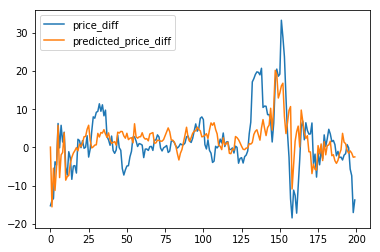

In [276]:
# 200 ngày đầu tiên
plt.plot(y9[:200], label="price_diff")
plt.plot(model9.predict(PolynomialFeatures(2).fit_transform(X9))[:200], label="predicted_price_diff")
plt.legend()

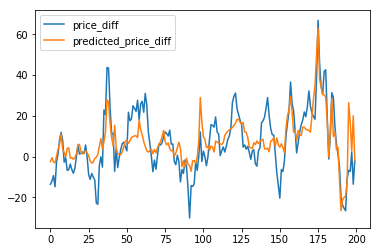

In [277]:
# 200 ngày cuối cùng
plt.plot(y9[-200:], label="price_diff")
plt.plot(model9.predict(PolynomialFeatures(2).fit_transform(X9))[-200:], label="predicted_price_diff")
plt.legend()

## References

[1] https://bitcoincharts.com/charts/bitstampUSD#rg60ztgSzm1g10zm2g25zv

[2] http://www.empirical.net/wp-content/uploads/2014/12/Fama-Random-Walks-in-Stock-Market-Prices.pdf

[3] http://ijssst.info/Vol-15/No-4/data/4923a105.pdf

[4] http://www.statsmodels.org/dev/tsa.html

[5] http://www.econ.yale.edu/~shiller/behfin/2001-05-11/chan.pdf